In [1]:
import torch
from torch_geometric.nn import GATConv
from torch_geometric.nn import GATv2Conv

In [2]:
import numpy as np

#### Technical functions

In [3]:
import h5py
import numpy as np
import pandas as pd

In [4]:
def load_nodesnedges_h5py(h5file, hash_mol):
    """
    Load data from one molecule (group) from a h5py
    file (h5file) using the specific hash (hash_mol).
    """
    # Load a specific molecule using the hash
    id_mol = f"sample_{hash_mol}"
    with h5py.File(h5file, 'r') as f:
        # Load global parameters
        global_params = dict(f.attrs)
        print("Global params:", global_params)

        # Access a specific sample using the hash
        sample = f[id_mol]
        # load arrays
        return [
            sample.attrs["name"],
            sample["Node_features"][:],
            sample["Edge_list"][:],
            sample["Edge_features"][:]
        ]

In [5]:
def loadseveral_nodesnedges_h5py(h5file):
    """
    Load data from several molecules (groups) from a h5py
    file (h5file).
    Do not use this function for hundreds/thousands of 
    molecules.
    """
    data = {}
    with h5py.File(h5file, 'r') as mol:
        for group_name in mol.keys(): # iteration through groups (molecules)
            group = mol[group_name]
            data[group_name] = {
                "features" : {
                    "Node_features": group["Node_features"][:], # Shape (#atoms, 14)
                    "Edge_list": group["Edge_list"][:], # Shape (2, atoms*(atoms-1))
                    "Edge_features": group["Edge_features"][:], # Shape (atoms*(atoms-1), 8)
                },
                "metadata": dict(group.attrs), # Name, hash
            }
    return data

###### Load data

In [6]:
#### Load H5PY file
h5file = 'data_50mol_test.h5'

In [7]:
# Load information from H5PY in a dictionary
raw_full_data = loadseveral_nodesnedges_h5py(h5file)

In [8]:
# Load and save all molecule node features in a single list
test50_nodesfeat = [raw_data['features']['Node_features'] for raw_data in raw_full_data.values()]

In [9]:
# Load and save all molecule edge list in a single list
# to correct in the previous code: all info is repeated, loading only one of them is enough
#test50_edgelist = [raw_data['features']['Edge_list'] for raw_data in raw_full_data.values()]
edgelist = raw_full_data['sample_f00']['features']['Edge_list']

In [10]:
# Load and save all molecule feature edge in a single list
test50_edgefeat = [raw_data['features']['Edge_features'] for raw_data in raw_full_data.values()]

##### Modification on data
###### Prepare input data

In [11]:
# Highlight flagged nodes (cross-feature flag) multupliting by 5
node_feats = [np.c_[nodefeat[:, :13], nodefeat[:, 13] * 5] for nodefeat in test50_nodesfeat]

In [12]:
# Highlight flagged edges (cross-feature flag) multupliting by 5 the second last column and by 2 the last one
edge_feats = [np.c_[nodedge[:, :-2], nodedge[:, -2:-1] * 5, nodedge[:, -1:] * 2] for nodedge in test50_edgefeat]

In [13]:
# Use Pytorch to transform data into tensors
from torch_geometric.data import Data

In [ ]:
# Diagnosis of the node features
#total of data points in node_feats
total = node_feats[0].shape[0] * node_feats[0].shape[1] * len(node_feats)
print(f"Total number of points: {total}, 100%")
#one-value points in node_feats
val_tmp = np.sum(np.array([np.where(node_feat == 1)[0].shape[0] for node_feat in node_feats]))
print(f"Number of one-value points: {val_tmp}, {(100*val_tmp)/total:.2f}%")
#zero-value points in node_feats
val_tmp = np.sum(np.array([np.where(node_feat == 0)[0].shape[0] for node_feat in node_feats]))
print(f"Number of zero-value points: {val_tmp}, {(100*val_tmp)/total:.2f}%")
#greater-than-one-value points in node_feats
val_tmp = np.sum(np.array([np.where(node_feat > 1)[0].shape[0] for node_feat in node_feats]))
print(f"Number of cross-feature flag points: {val_tmp}, {(100*val_tmp)/total:.2f}%")

In [ ]:
# Diagnosis of the edge features
#total of data points in edge_feats
total = edge_feats[0].shape[0] * edge_feats[0].shape[1] * len(edge_feats)
print(f"Total number of points: {total}, 100%")
#one-value points in edge_feats
val_tmp = np.sum(np.array([np.where(edge_feat == 1)[0].shape[0] for edge_feat in edge_feats]))
print(f"Number of one-value points: {val_tmp}, {(100*val_tmp)/total:.2f}%")
#zero-value points in edge_feats
val_tmp = np.sum(np.array([np.where(edge_feat == 0)[0].shape[0] for edge_feat in edge_feats]))
print(f"Number of zero-value points: {val_tmp}, {(100*val_tmp)/total:.2f}%")
#three-value points in edge_feats
val_tmp = np.sum(np.array([np.where(node_feat == 150)[0].shape[0] for node_feat in edge_feats]))
print(f"Number of cross-feature flag points part 1: {val_tmp}, {(100*val_tmp)/total:.5f}%")
#ten-value points in edge_feats
val_tmp = np.sum(np.array([np.where(node_feat == 500)[0].shape[0] for node_feat in node_feats]))
print(f"Number of cross-feature flag points part 2: {val_tmp}, {(100*val_tmp)/total:.5f}%")
#non-integer-value points in edge_feats
val_tmp = np.sum(np.array([np.where(
    (edge_feat != 500) & (edge_feat != 150) & (edge_feat != 1) & (edge_feat != 0)
)[0].shape[0] for edge_feat in edge_feats]))
print(f"Number of real-value points: {val_tmp}, {(100*val_tmp)/total:.2f}%")

#### GAT model

In [14]:
# Create PyG Data object for more "molecules"
number_of_mol = len(node_feats) # total of group data
pyg_data_list = [
    Data(
        x=torch.tensor(node_feats[i], dtype=torch.float32),
        edge_index=torch.tensor(edgelist, dtype=torch.long),
        edge_attr=torch.tensor(edge_feats[i], dtype=torch.float32)
    )
    for i in range(number_of_mol)  # For 50 molecules
]

In [15]:
print("Number of edges:", pyg_data_list[0].edge_index.shape[1])  # Should be 1980
print("Edge features shape:", pyg_data_list[0].edge_attr.shape)  # Must be [1980, 8]
assert pyg_data_list[0].edge_index.shape[1] == pyg_data_list[0].edge_attr.shape[0]

Number of edges: 1980
Edge features shape: torch.Size([1980, 8])


In [16]:
#GAT Layer (two-head)
#conv = GATConv(
conv = GATv2Conv(           # dynamic attention, less prone to softmax suppression
    in_channels=14,         # Matches node feature dim (14)
    out_channels=64,        # Embedding dimension
    heads=2,                # 1 head to simplify debugging
    edge_dim=8,             # Matches edge_attr dim (8)
    concat=True,            # Combines multi-head outputs (preserves all dimensions; required for sparse feature retention)
    add_self_loops=False,    # Disable if edges are already undirected
    bias=False,  # Disable to prevent drowning sparse signals
    #negative_slope=0.5  # Less aggressive than default LeakyReLU (avoids over-squashing near-zero edges)
    negative_slope=0.01,    # to make attention more sensitive to small values.
    dropout=0.0             # (temporarily) to prevent masking rare flags
)

In [17]:
# to load and pool data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool

In [18]:
mol_embeddings = []  # Will store all molecule embeddings
# Data set is pyg_data_list
loader = DataLoader(pyg_data_list, batch_size=5)

for batch in loader:
    # batch.x: [num_nodes_in_batch, 14]
    #print(batch.x.shape)
    # batch.edge_index: [50, num_edges_in_batch]
    #print(batch.edge_index.shape)
    # batch.batch: Maps nodes to their molecule ID 
    #print(batch.batch.shape)

    # Node embeddings: [total_nodes_in_batch, 64]
    node_embeddings = conv(batch.x, batch.edge_index, batch.edge_attr)

    # Pool to graph-level: [batch_size, 64]
    mol_embed = global_mean_pool(node_embeddings, batch.batch)  # [50, 64]
    mol_embeddings.append(mol_embed)

In [19]:
# Concatenate all batches -> [num_molecules, 64]
mol_embeddings = torch.cat(mol_embeddings, dim=0)

In [20]:
mol_embeddings.shape

torch.Size([50, 64])

In [ ]:
# Diagnosis of the GAT embeddings
print("max and min: ", mol_embeddings_np.max(), mol_embeddings_np.min())
print("std and mean: ", mol_embeddings_np.std(), mol_embeddings_np.mean())
print("data points inside range -4.4 < x < 5.4: ",
      (100 * np.where((mol_embeddings_np > -4.4) & (mol_embeddings_np < 5.4))[0].shape[0])
      / (mol_embeddings_np.shape[0] * mol_embeddings_np.shape[1]),"%")
print("dat points inside range x < -9.4 or x > 11.4: ", 
      (100 * np.where((mol_embeddings_np < -9.4) | (mol_embeddings_np > 11.4))[0].shape[0])
      / (mol_embeddings_np.shape[0] * mol_embeddings_np.shape[1]),"%")
print("total data points: ",
      mol_embeddings_np.shape[0] * mol_embeddings_np.shape[1])

#### Cluster model

In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.cluster import DBSCAN

In [29]:
import matplotlib.pyplot as plt

In [30]:
def plot_k_distance(data, k=3, normalization_name=""):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, _ = neigh.kneighbors(data)
    k_distances = np.sort(distances[:, -1])  # Distance to k-th NN
    
    plt.figure(figsize=(10,6))
    plt.plot(k_distances)
    plt.title(f'k-Distance Plot ({normalization_name}, k={k})')
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'Distance to {k}-th NN')
    plt.axhline(y=np.percentile(k_distances, 85), color='r', linestyle='--') 
    plt.grid(True)
    plt.show()
    
    print(f"Suggested eps range for {normalization_name}:")
    print(f"Min: {np.percentile(k_distances, 70):.2f}")
    print(f"Max: {np.percentile(k_distances, 90):.2f}")

In [31]:
def plot_k_cosine(data, k=3, normalization_name="L2_normalization"):
    neigh = NearestNeighbors(n_neighbors=k, metric='cosine')
    neigh.fit(data)
    distances, _ = neigh.kneighbors(data)
    k_distances = np.sort(distances[:, -1])  # Distance to k-th NN
    
    plt.figure(figsize=(10,6))
    plt.plot(k_distances)
    plt.title(f'k-Distance Plot ({normalization_name}, k={k})')
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'Distance to {k}-th NN')
    plt.axhline(y=np.percentile(k_distances, 85), color='r', linestyle='--') 
    plt.grid(True)
    plt.show()
    
    print(f"Suggested eps range for {normalization_name}:")
    print(f"Min: {np.percentile(k_distances, 70):.2f}")
    print(f"Max: {np.percentile(k_distances, 90):.2f}")

In [32]:
# If mol_embeddings is a torch.Tensor (shape [2, 64])
mol_embeddings_np = mol_embeddings.detach().cpu().numpy()  # Shape: [N, 64]

In [33]:
# Normalize embeddings before DBSCAN to balance direction
#  'cosine' and magnitude 'euclidean' metrics
# Scale to [0,1] range
mol_embeddings_norm = StandardScaler().fit_transform(mol_embeddings_np)
#mol_embeddings_norm = MinMaxScaler().fit_transform(mol_embeddings_np)

In [34]:
from sklearn.neighbors import NearestNeighbors

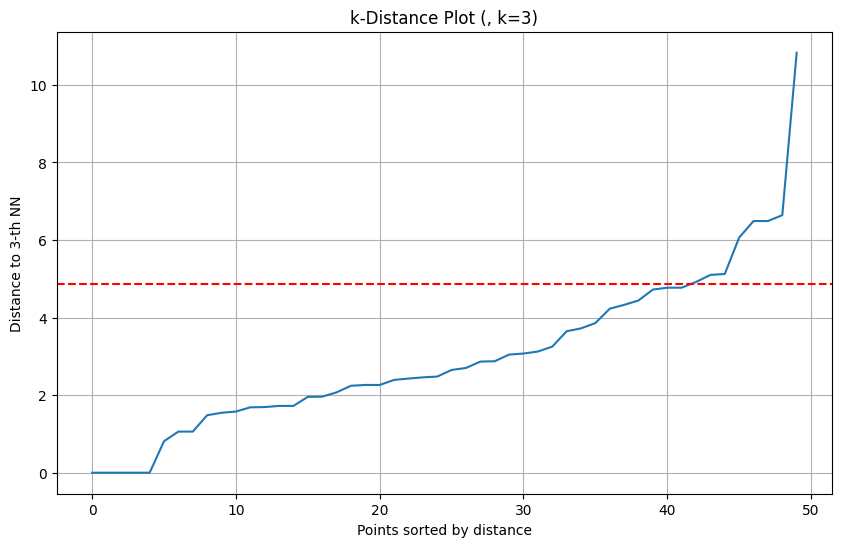

Suggested eps range for :
Min: 3.76
Max: 5.22


In [35]:
plot_k_distance(StandardScaler().fit_transform(mol_embeddings_np))

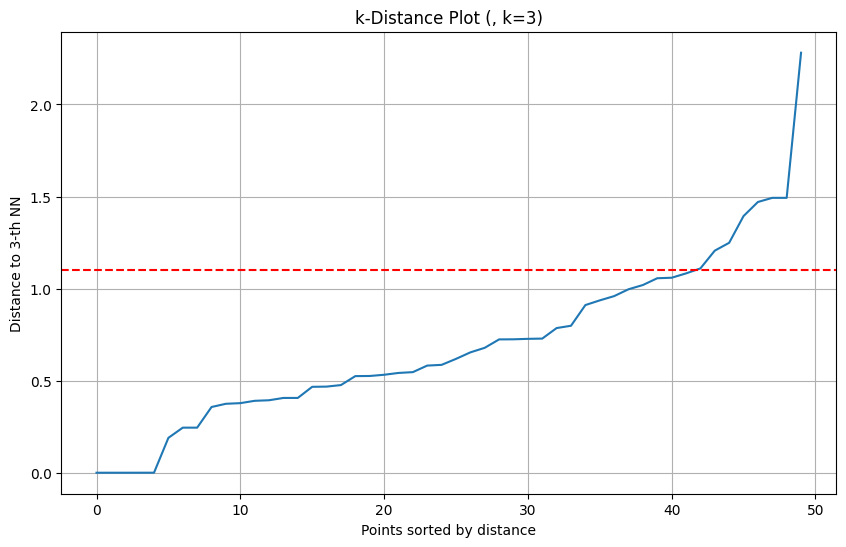

Suggested eps range for :
Min: 0.92
Max: 1.26


In [36]:
plot_k_distance(MinMaxScaler().fit_transform(mol_embeddings_np))

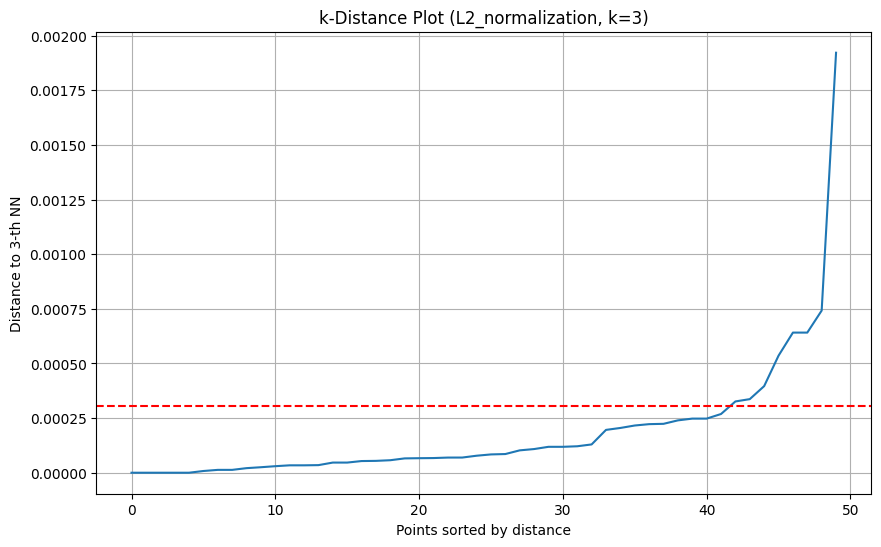

Suggested eps range for L2_normalization:
Min: 0.00
Max: 0.00


In [37]:
plot_k_cosine(normalize(mol_embeddings_np))

In [38]:
# For Standard normalized data
mol_embeddings_norm = StandardScaler().fit_transform(mol_embeddings_np)
dbscan = DBSCAN(eps=5.03, min_samples=3).fit(mol_embeddings_norm) #eps = 2.1 same results as MinMaxScaler()
print(dbscan.labels_)
print(np.unique(dbscan.labels_, return_counts=True))

[ 0 -1  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 -1  0  0 -1  0  0  0  0  0 -1  0  0  0  0
  0  0]
(array([-1,  0]), array([ 5, 45]))


In [39]:
# For MinMax normalized data
mol_embeddings_norm = MinMaxScaler().fit_transform(mol_embeddings_np)
dbscan = DBSCAN(eps=1.17, min_samples=3).fit(mol_embeddings_norm)
print(dbscan.labels_)
print(np.unique(dbscan.labels_, return_counts=True))

[ 0 -1  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 -1  0 -1 -1  0  0  0  0  0 -1  0  0  0  0
  0  0]
(array([-1,  0]), array([ 6, 44]))


In [40]:
# Cluster based on cosine similarity (now magnitude-insensitive)
mol_embeddings_norm = normalize(mol_embeddings_np)
dbscan = DBSCAN(eps=0.1, min_samples=3, metric='cosine').fit(mol_embeddings_norm)  
print(dbscan.labels_)  # e.g., [0, 1] (two clusters) or [0, 0] (one cluster)
print(np.unique(dbscan.labels_, return_counts=True))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
(array([0]), array([50]))


In [41]:
# Visualize (if 2D/3D)
import matplotlib.pyplot as plt

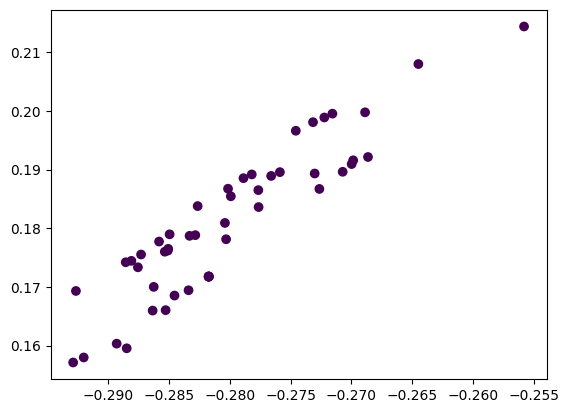

In [42]:
plt.scatter(mol_embeddings_np[:,1], mol_embeddings_np[:, 32], c=dbscan.labels_)
plt.show()